In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [3]:
def lorenz(x, t):

    sig = 10.0
    rho = 28.0
    beta = 8.0/3

    dx = np.empty(3)
    dx[0] = sig*(x[1] - x[0])
    dx[1] = x[0]*(rho - x[2]) - x[1]
    dx[2] = x[0]*x[1] - beta * x[2]

    return dx

def make_lagged_data(y, N_lags):
    data = []
    assert y.ndim == 2  # Nt x Nsignals
    y = np.vstack([np.ones((N_lags, y.shape[1]))*np.nan, y])  # prepend nans
    for i in range(N_lags):
        data.append(np.roll(y, i, axis = 0))
    data = np.hstack(data)
    data = data[N_lags:, :]
    return data

def diff_data(y):
    dy = np.diff(y, axis = 0)
    dy = np.vstack([dy, np.ones((1, dy.shape[1]))*np.nan])  # prepend nans
    return dy


def get_targets_and_predictors(N_lags = 3):
    y0 = (np.random.rand(3)-.5)*100
    t = np.arange(0, .1, .001)
    y = odeint(lorenz,y0,t)
    y = y[:,:]

    predictors = make_lagged_data(y, N_lags)
    targets = diff_data(y)

    targets = targets[:, None, :]  # reshape to [sample, timepoint, features]
    predictors = predictors[:, None, :]  # reshape to [sample, timepoint, features]


    # last some rows will have nans, so do not use
    targets = targets[N_lags:-1, :, :]
    predictors = predictors[N_lags:-1, :, :]

    assert np.any(np.isnan(targets)) == False
    assert np.any(np.isnan(predictors)) == False


    predictors = torch.tensor(predictors, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)

    return predictors, targets


predictors = []
targets = []
for i in range(20000):
    p, t = get_targets_and_predictors()
    predictors.append(p)
    targets.append(t)

predictors = np.concatenate(predictors)
targets = np.concatenate(targets)

predictors = torch.tensor(predictors, dtype = torch.float32)
targets = torch.tensor(targets, dtype = torch.float32)

print(predictors.shape)
print(targets.shape)

pmax = torch.max(torch.abs(predictors[:]))
tmax = torch.max(torch.abs(targets[:]))
print(pmax, tmax)

predictors = predictors/pmax
targets = targets/tmax


X_train, X_test, Y_train, Y_test = train_test_split(predictors, targets)



torch.Size([1920000, 1, 9])
torch.Size([1920000, 1, 3])
tensor(111.7552) tensor(4.6826)


In [4]:

model = nn.Sequential(
    nn.Linear(9, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 3),
    nn.Tanh(),
)

loss_fn   = nn.MSELoss()  # mean squared error loss
optimizer = torch.optim.Adam(model.parameters(),
                              lr=0.001)

n_epochs = 2000
losses = np.empty(n_epochs)
test_losses = np.empty(n_epochs)

print(model)

for epoch in range(n_epochs):
        Y_pred = model(X_train)
        Y_pred_test = model(X_test)
        loss = loss_fn(Y_pred, Y_train)
        loss_test = loss_fn(Y_pred_test, Y_test)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch %10 ==0:
            print(f'epoch {epoch}, loss = {loss}, test loss = {loss_test}')
        losses[epoch] = loss.detach().numpy()
        test_losses[epoch] = loss_test.detach().numpy()


Sequential(
  (0): Linear(in_features=9, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=3, bias=True)
  (7): Tanh()
)
epoch 0, loss = 0.030800336971879005, test loss = 0.030767453834414482
epoch 10, loss = 0.025174932554364204, test loss = 0.02514934353530407
epoch 20, loss = 0.023411031812429428, test loss = 0.023389358073472977
epoch 30, loss = 0.023196576163172722, test loss = 0.02317693643271923
epoch 40, loss = 0.022983068600296974, test loss = 0.022964974865317345
epoch 50, loss = 0.022769654169678688, test loss = 0.022752344608306885
epoch 60, loss = 0.02263055182993412, test loss = 0.02261393517255783
epoch 70, loss = 0.0224760714918375, test loss = 0.0224600937217474
epoch 80, loss = 0.022310981526970863, test loss = 0.02229560725390911
epoch 90, loss = 0.02212383970618248, test loss = 0.0221091210

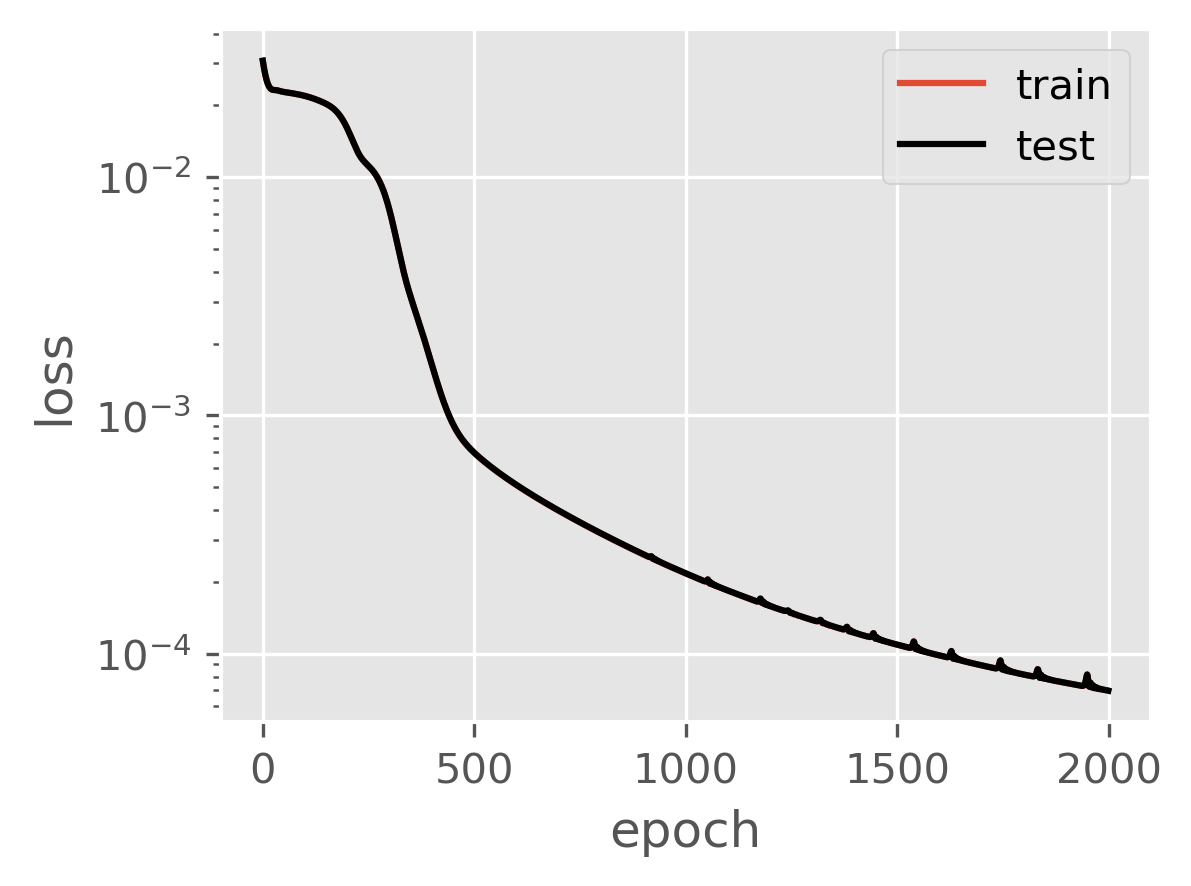

In [5]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(losses, label = 'train')
ax.plot(test_losses, label = 'test', c = 'k')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.set_size_inches(4, 3)
fig.set_dpi(300)


In [8]:
y0 = np.array([1, 0, 1])
t = np.arange(0, 10, .001)
y = odeint(lorenz,y0,t)


y_NN = np.empty((len(t), 3))
y_NN[0:2, :] = y[0:2, :]


y_NN = torch.tensor(y_NN, dtype = torch.float32)

for i in range(2,len(t)-1):
    predictors = torch.concatenate([y_NN[i,:], y_NN[i-1,:], y_NN[i-2,:]])  # should change this to a reshape
    dy = model(predictors/pmax)
    y_NN[i+1,:] = y_NN[i,:] + dy*tmax
    if i%100 == 0:
        print(i/len(t))


0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


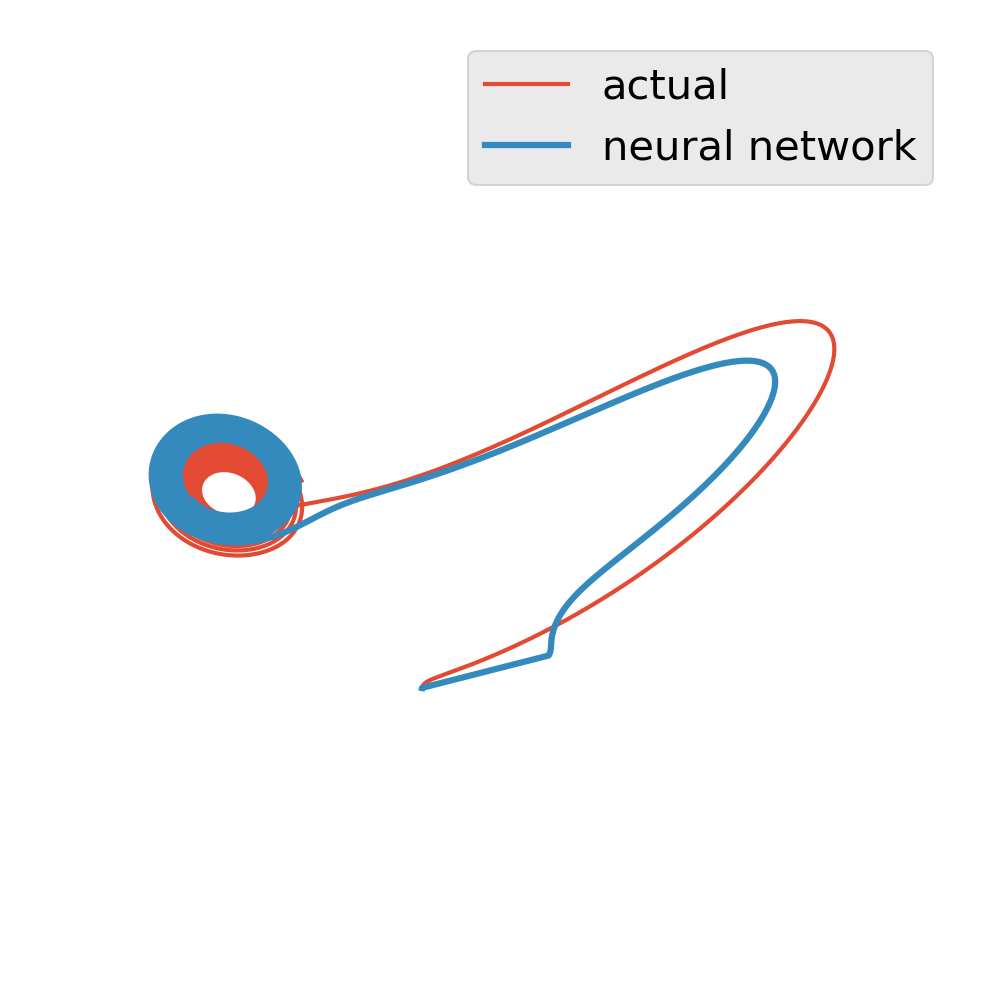

In [9]:


fig = plt.figure()
fig.set_facecolor('w')
fig.set_size_inches(8,4)
fig.set_dpi(300)
fig.tight_layout(pad = 0)

ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor("w")
ax.set_axis_off()

ax.plot3D(y[:,0], y[:,1], y[:,2], label = 'actual', linewidth = 1)
ax.plot3D(y_NN[:,0].detach().numpy(), y_NN[:,1].detach().numpy(), y_NN[:,2].detach().numpy(), label = 'neural network')

ax.legend()